In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scipy.io
import helper_functions.helper_functions as helper
import imageio
import cv2
import forward_model as fm

# Change this to GPU or CPU depending on your machine
%run fista_svd.py CPU

device =  CPU , using CPU and numpy


In [2]:
if device == 'GPU':
    import cupy as np
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    np.cuda.Device(0).use()
else:
    import numpy as np

# Code to run SVD-FISTA benchmark (spatially-varying FISTA)

## Step 1: Load in SVD weights (PSFs and weights) 

Load forward model weights (these are extracted from the measured PSFs using the SVD model).

H and weights are extracted from SVD of the PSFS. crop indices used to crop the image to the correct size. 

load_weights_3d loads the weights, and also precomputes the FFT of the PSFs for FISTA. This can take some time depending on the size of the PSFs. 

In [3]:
path_weights = '/home/kyrollos/LearnedMiniscope3D/RandoscopePSFS/SVD_2_5um_PSF_5um_1_ds4_dsz1_weights_green_SubAvg.mat'
path_psfs = '/home/kyrollos/LearnedMiniscope3D/RandoscopePSFS/SVD_2_5um_PSF_5um_1_ds4_dsz1_comps_green_SubAvg.mat'


In [4]:
H,weights,crop_indices = fm.load_weights_3d(path_psfs, path_weights)

H = H[:,:,0::4]
weights = weights[:,:,0::4]

In [5]:
H.shape

(972, 1296, 8, 12)

In [6]:
weights.shape

(486, 648, 8, 12)

## Step 2: Load in real data or use forward model to simulate measurement


In [7]:
data = 'real'  # 'sim' or 'real'  
#real_path = '../data/real_data/resTargetZ_1.mat'
#sim_path = '../data/hydra3.jpg'

measurement shape: (486, 648)


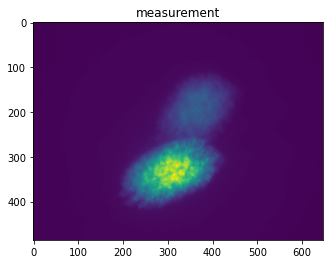

In [8]:
import glob
if data == 'real':
    
    img_ind = 1 # 0: resolution target, 1: waterbear
    loaded_meas = glob.glob('../data/real_data/*')
    meas = scipy.io.loadmat(loaded_meas[img_ind])['b']

    
    plt.imshow(meas);
    plt.title('measurement');
    print('measurement shape:', meas.shape)

elif data == 'sim':
    im_in=imageio.imread(sim_path)
    im_in=np.sum(im_in,-1)/3
    im=cv2.resize(im_in,(weights.shape[1],weights.shape[0]))

    plt.imshow(im);
    plt.title('object');
    print('object shape:', im.shape)
    plt.show()
    
    # simulate data
    meas=fm.sim_data(im,H,weights,crop_indices)
    plt.imshow(meas);
    plt.title('simulated measurement');
    print('measurement shape:', sim.shape)
    
else:
    print('Error. Specify whether simulated or real data')

## Step 3: Initialize FISTA & place on GPU

In [9]:
# Place variables on GPU if using GPU
H = H/numpy.max(H)

if device == 'GPU': 
    H = np.asarray(H)
    weights = np.asarray(weights)
    meas = np.asarray(meas)
    crop_indices = np.asarray(crop_indices)
    
# Initialize FISTA with H, weights, and crop indices 
fista = fista_svd(H, weights, crop_indices, obj_type = '3D')

# Default: tv, Options: 'native' for native sparsity, 'non-neg' for enforcing non-negativity only
fista.iters = 500             
fista.prox_method = 'tv'  
fista.tv_lambda  = .0003    # tuning parameter for TV, larger is more TV
fista.tau = 0.003           # tuning parameter for native sparsity, larger is more sparse

(972, 1296)
(972, 1296)
(972, 1296)
(972, 1296)
(972, 1296)
(972, 1296)
(972, 1296)
(972, 1296)
(972, 1296)
(972, 1296)


## Step 4: Run SVD-FISTA reconstruction

iteration:  0  loss:  6419.444726450476


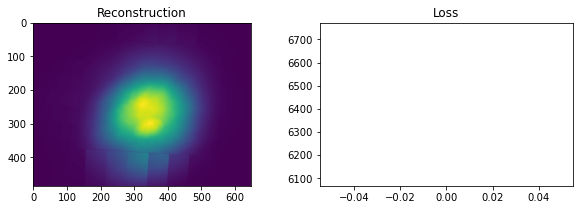

iteration:  20  loss:  3630.6645924487693


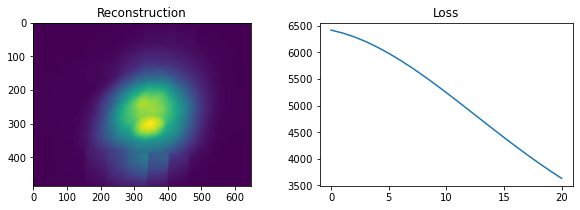

iteration:  40  loss:  2256.9975977949257


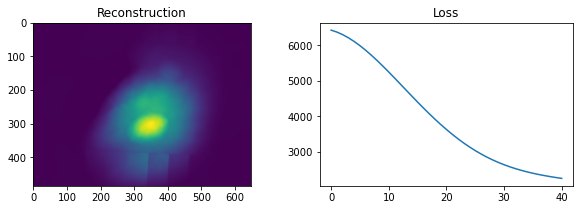

iteration:  60  loss:  1861.8182002329252


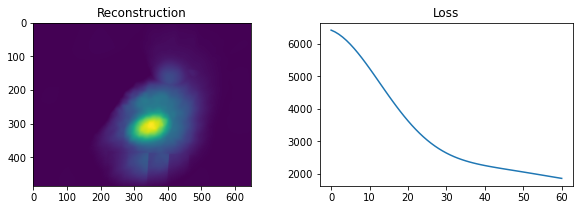

iteration:  80  loss:  1549.1237247720906


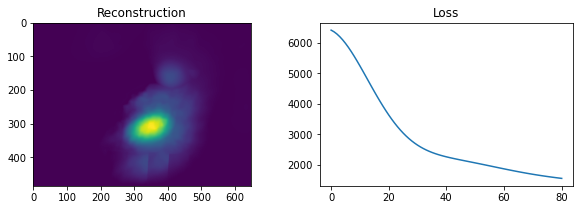

iteration:  100  loss:  1357.747689663563


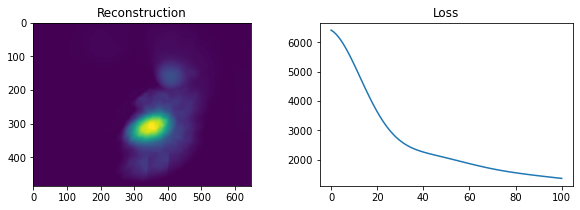

iteration:  120  loss:  1206.5026508646743


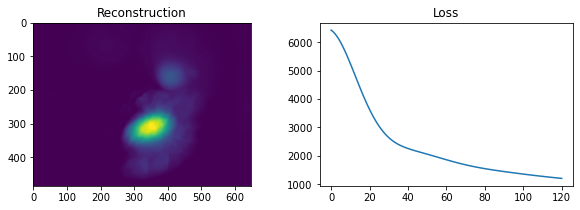

iteration:  140  loss:  1089.143649721657


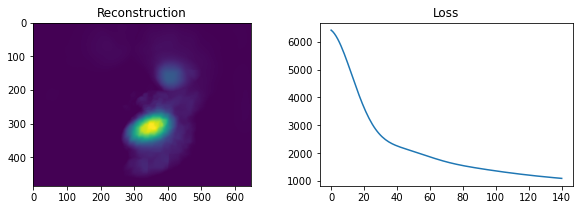

iteration:  160  loss:  993.4284745236562


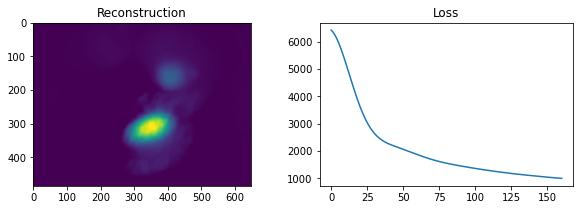

iteration:  180  loss:  916.9983959304823


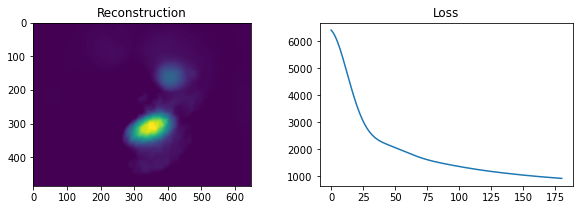

iteration:  200  loss:  856.9122561891268


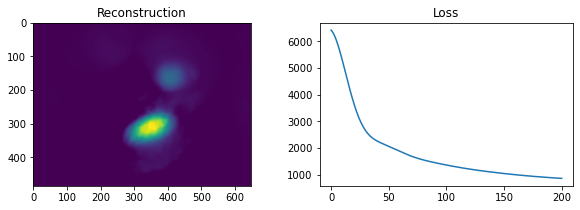

iteration:  220  loss:  809.1153994646847


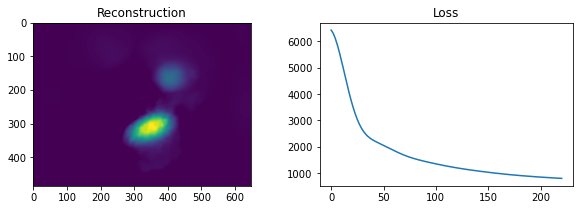

iteration:  240  loss:  770.3531199160573


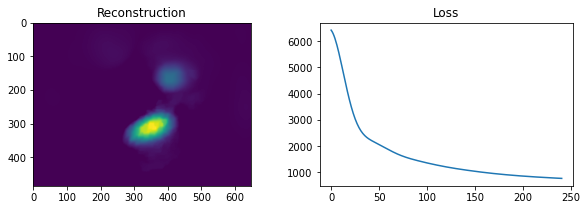

iteration:  260  loss:  738.5636200883698


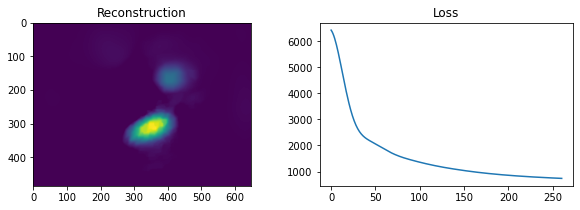

iteration:  280  loss:  710.8582444603483


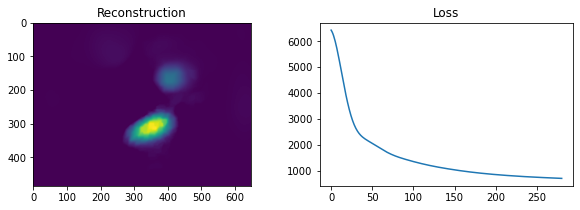

iteration:  300  loss:  686.9031091915477


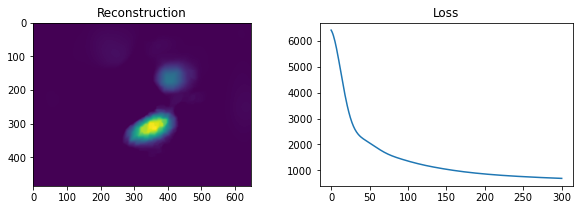

iteration:  320  loss:  667.2270951032406


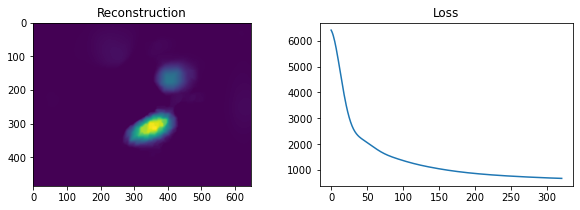

iteration:  340  loss:  650.6509575933638


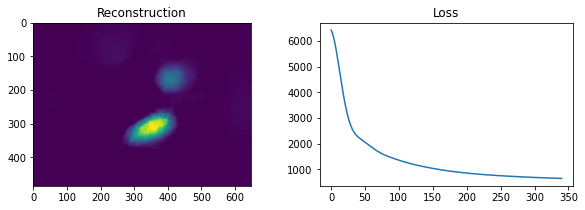

iteration:  360  loss:  639.4697961123849


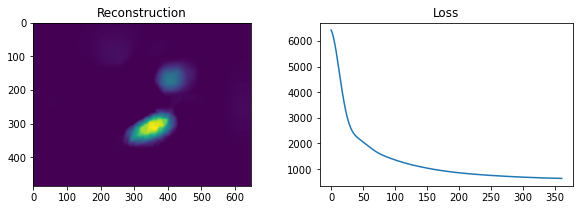

iteration:  380  loss:  632.056347167613


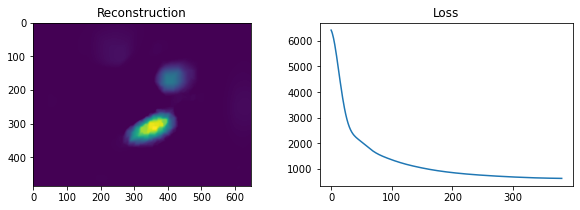

iteration:  400  loss:  624.6054349841446


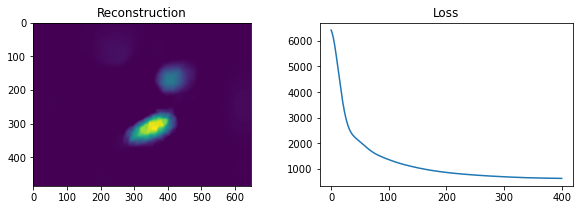

iteration:  420  loss:  617.456317384131


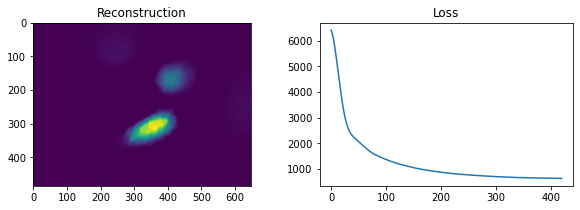

iteration:  440  loss:  610.9871898640406


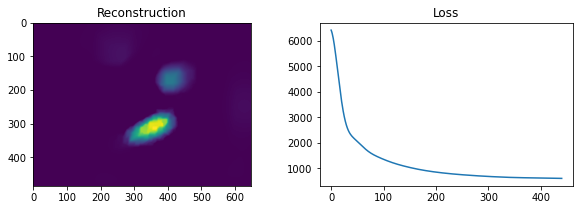

iteration:  460  loss:  605.673276777486


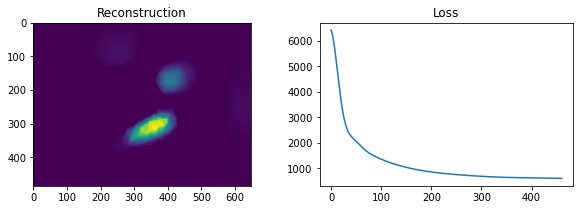

iteration:  480  loss:  601.0367536852527


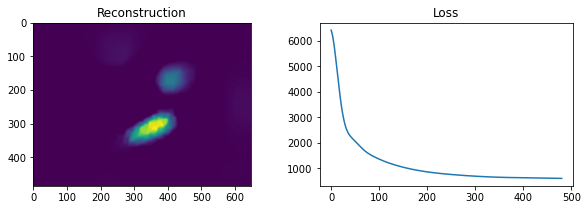

In [10]:
out_img = fista.run(meas)